In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import sys
import pysam
import operator
from collections import defaultdict
from Bio import SeqIO
import pandas as pd

In [55]:
## get seqs
import gzip
import taxoniq
from Bio import SeqIO

mammals = {}
non_mammals = {}


seqs = {}
with gzip.open('../mitochondria_dereplicated98.fasta.gz', 'rt') as handle:
    for record in SeqIO.parse(handle, 'fasta'):
        # Process each record as needed
        seqs[record.id] = record.seq

        acc = record.description.split()[0]
        name = " ".join(record.description.replace(" UNVERIFIED: ", " ").split()[1:3])

        try:
            t = taxoniq.Taxon(scientific_name=name)
            ranks = [(t.rank.name, t.scientific_name) for t in t.ranked_lineage]
            species = ''
            genus = ''
            for rank in ranks:
                if rank[0] == 'species':
                    species = rank[1]
                if rank[0] == 'genus':
                    genus = rank[1]

            if ('class', 'Mammalia') in ranks:
                mammals[acc] = species
            else:
                non_mammals[acc] = species

        except:
            pass


In [50]:
### Get expected data
expected = []
for fn in glob.glob('./data/*coverage.txt'):
    fn_name = fn.split("/")[-1].split("_coverage.txt")[0]

    f = open(fn)
    i = 0 
    for line in f.readlines():
        seq = "_".join(line.split()[0].split("_")[:-2])
        species = " ".join(line.split()[0].split("_")[-2:])
        genus = line.split()[0].split("_")[-2]

        coverage = float(line.split()[-1].strip())

        expected.append({"File":fn_name,"seq":seq,"genus":genus,"species":species,"coverage":coverage, "mutated":float(fn_name.split("_m")[1].split("_")[0])})
        # print(line.strip())
        i += 1
        if i == 60:
            break
expected = pd.DataFrame(expected)
expected

,File,seq,genus,species,coverage,mutated
0,mt_simulated_m0.01_11,NC_046932.1,Scotonycteris,Scotonycteris zenkeri,13.012235,0.01
1,mt_simulated_m0.01_11,NC_023795.1,Macaca,Macaca assamensis,1.019704,0.01
2,mt_simulated_m0.01_11,NC_023210.1,Mustela,Mustela kathiah,0.651500,0.01
3,mt_simulated_m0.01_11,NC_072603.1,Dendrogale,Dendrogale murina,1.346071,0.01
4,mt_simulated_m0.01_11,NC_034727.1,Lepilemur,Lepilemur septentrionalis,8.969862,0.01
...,...,...,...,...,...,...
23995,mt_simulated_m0.01_97,NC_063472.1,Hestina,Hestina persimilis,0.977833,0.01
23996,mt_simulated_m0.01_97,NC_015825.1,Pelochelys,Pelochelys cantorii,0.728381,0.01
23997,mt_simulated_m0.01_97,NC_036344.1,Gelochelidon,Gelochelidon nilotica,1.607777,0.01
23998,mt_simulated_m0.01_97,NC_021422.1,Hyattella,Hyattella sinuosa,1.018214,0.01


In [11]:
def read_bam(bamfile, seqs):
    
    samfile = pysam.AlignmentFile(bamfile, "rb")
    fn_name = bamfile.split(".bam")[0].split("/")[-1]

    results = defaultdict(list)
    for seq in seqs:
        read_count = 0
        covered_positions = set()
        reads = set()

        for read in samfile.fetch(seq, 200, len(seqs[seq])-200):
            read_len = len(read.get_reference_positions())
            read_pid = 1 - (int(read.get_tag("NM")) / read_len)
            if read_pid >= 0.95:
                if len(read.get_reference_positions()) >= 40 and read.mapping_quality >= 20:
                    covered_positions.update(read.get_reference_positions())
                    if read.query_name not in reads: # Only count pairs once
                        read_count += 1
                        reads.add(read.query_name)

        results['Sample_Name'].append(fn_name)
        results['reference'].append(seq)
        results['read_count'].append(read_count)
        results['covered_bases'].append(len(covered_positions))

    results = pd.DataFrame(results)
    results = results[results['covered_bases'] >= breadth_cutoff]

    return results

In [97]:
def calculate_specificity_sensitivity(results, expected_seqs, breadth_cutoff = 1):
    
    specificity = 0 
    sensitivity = 0
    results = results[results.covered_bases >= breadth_cutoff]

    specificity = results[results.reference.isin(expected_seqs.seq)].shape[0] / results.shape[0]
    
    sensitivity = results[results.reference.isin(expected_seqs.seq)].shape[0] / 20.0 ## 20 mammalian mt per sample
    ## calculate specificity 
    # for index, row in results['reference']:


    return sensitivity, specificity

In [98]:
final = []
for fn in glob.glob('./data/*.bam'):
    fn_results = read_bam(fn, seqs)
    fn_results = fn_results[fn_results.reference.isin(mammals)]
    fn_name = fn.split("/")[-1].split("__mt98.bam")[0]
    print(fn_name)
    fn_expected = expected[expected.File == fn_name]
    for cutoff in range(1,1000, 10):
        sensitivity, specificity = calculate_specificity_sensitivity(fn_results, expected, breadth_cutoff = cutoff)
        final.append({"Sample":fn_name, "breadth_cutoff":cutoff, "sensitivity":sensitivity, "specificity":specificity, "mutated": float(fn_name.split("_m")[1].split("_")[0])})

mt_simulated_m0.03_1
mt_simulated_m0.03_90
mt_simulated_m0.05_94
mt_simulated_m0.03_99
mt_simulated_m0_82
mt_simulated_m0_53
mt_simulated_m0.01_74
mt_simulated_m0.01_8
mt_simulated_m0.01_76
mt_simulated_m0.03_70
mt_simulated_m0.01_77
mt_simulated_m0_59
mt_simulated_m0_5
mt_simulated_m0.05_82
mt_simulated_m0.05_90
mt_simulated_m0.03_0
mt_simulated_m0.03_53
mt_simulated_m0_38
mt_simulated_m0.03_55
mt_simulated_m0.01_41
mt_simulated_m0_78
mt_simulated_m0.01_58
mt_simulated_m0_81
mt_simulated_m0_13
mt_simulated_m0.01_10
mt_simulated_m0.03_46
mt_simulated_m0.01_26
mt_simulated_m0.01_63
mt_simulated_m0.03_15
mt_simulated_m0_37
mt_simulated_m0_28
mt_simulated_m0.05_23
mt_simulated_m0.05_71
mt_simulated_m0.01_17
mt_simulated_m0.05_30
mt_simulated_m0.03_13
mt_simulated_m0.05_61
mt_simulated_m0.01_98
mt_simulated_m0.01_46
mt_simulated_m0.05_31
mt_simulated_m0.01_4
mt_simulated_m0.05_95
mt_simulated_m0.05_47
mt_simulated_m0.03_43
mt_simulated_m0_69
mt_simulated_m0.01_83
mt_simulated_m0.03_78
mt_s

In [99]:
final = pd.DataFrame(final)

In [122]:
## svg fonts as text
plt.rcParams['svg.fonttype'] = 'none'

/home/alex/miniconda3/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/alex/miniconda3/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/alex/miniconda3/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/alex/miniconda3/lib/python3.9/site-packages/se

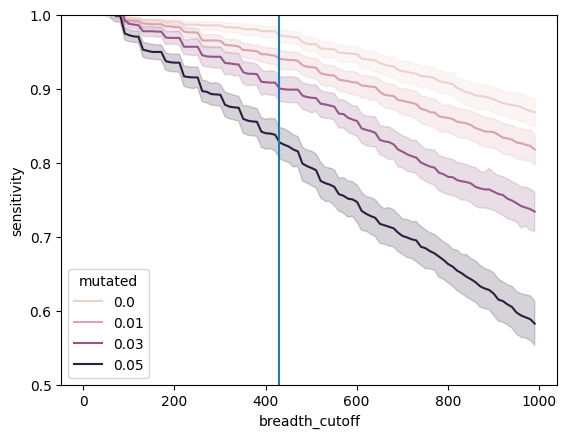

In [123]:
sns.lineplot(data=final, x="breadth_cutoff", y="sensitivity", hue="mutated")
plt.ylim(0.5,1)
plt.axvline(430)
plt.savefig("sensitivity.svg")

/home/alex/miniconda3/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/alex/miniconda3/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/alex/miniconda3/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/alex/miniconda3/lib/python3.9/site-packages/se

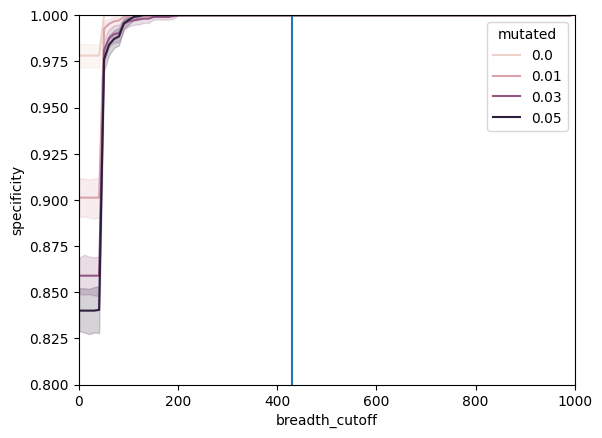

In [124]:
sns.lineplot(data=final, x="breadth_cutoff", y="specificity", hue="mutated")
plt.ylim(0.8, 1.0001)
plt.xlim(0,1000)
plt.axvline(430)
plt.savefig("specificity.svg")

In [131]:
final.query("breadth_cutoff == 431").specificity.mean()

1.0

In [132]:
final.query("breadth_cutoff == 431").specificity.min()

1.0

In [134]:
final.query("breadth_cutoff == 431").sensitivity.mean()

0.91025

In [137]:
expected.coverage.mean()

3.3756821182779326

In [140]:
expected.coverage.median()

2.00330688445253

In [141]:
expected.coverage.min()

0.029252509489788487